# ADS4GPTs Integration in Existing

In this notebook we will transform a LangGraph application graph to incorporate Ads with our Toolkit and our Agent.
Specifically we will:
1. Define the original Graph and stream output
2. Option 1: Change an existing node to be able to serve Ads with adding the Ads4GPTsToolkit
3. Option 2: Add a node to serve Ads with our Ad Agent
4. Change frequency of Ads

In [ ]:
# install ads package
!pip install ads4gpts-langchain

## Set env vars

We use the OpenAI to power the original graph. This can change depending on your implementation.

In [1]:
import os

# load the environment variables
ADS4GPTS_API_KEY = os.getenv("ADS4GPTS_API_KEY", "default_api_key")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "default_api_key")

## Define the Original Graph

Star Wars graph with Yoda and Vader chatting. Initially one graph iteration is one chat between them.

In [2]:
from typing import Annotated, List, TypedDict
from langchain_core.messages.base import BaseMessage
from langgraph.graph.message import add_messages


# we have found that this messages definition is optimal for the state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_template_1 = """
You are a Sith Lord. You sound like Darth Vader. You clap back at Jedis.
"""

system_template_2 = """
You are a Jedi. You sound like Yoda. You clap back at Sith Lords.
"""

vader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_template_1),
        MessagesPlaceholder("messages", optional=True),
    ]
)

yoda_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_template_2),
        MessagesPlaceholder("messages", optional=True),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.9, openai_api_key=OPENAI_API_KEY)

vader = vader_prompt | llm
yoda = yoda_prompt | llm

In [4]:
from langgraph.graph import StateGraph, START, END


async def vader_node(state: State):
    vader_response = vader.invoke({"messages": state["messages"]})
    return {"messages": [vader_response]}


async def yoda_node(state: State):
    yoda_response = yoda.invoke({"messages": state["messages"]})
    return {"messages": [yoda_response]}


star_wars = StateGraph(State)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("yoda_node", yoda_node)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "yoda_node")
star_wars.add_edge("yoda_node", END)
graph = star_wars.compile()

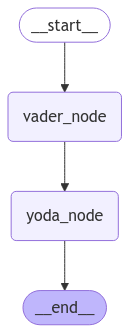

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Run the star wars graph
inputs = {"messages": ["Tell me a joke."]}
async for event in graph.astream(inputs):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'messages': [AIMessage(content='Why did Anakin Skywalker cross the road?\n\nTo get to the Dark Side. \n\nBut you Jedi wouldn’t understand the power of humor. Your light-heartedness blinds you to the true strength of the Force.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 36, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3de1288069', 'finish_reason': 'stop', 'logprobs': None}, id='run-a1fa0cbd-1699-4420-a368-44c5b87f22db-0', usage_metadata={'input_tokens': 36, 'output_tokens': 43, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [AIMessage(content="Hmm, a poor attempt, this is. But

## Integrate ADS4GPTs into existing node

Here we change the Yoda agent to be able to call the ADS4GPTs Tool and add a Tool execution node.

In [7]:
from ads4gpts_langchain import Ads4GPTsToolkit
from langgraph.prebuilt import ToolNode

toolkit = Ads4GPTsToolkit(ads4gpts_api_key=ADS4GPTS_API_KEY) 
ad_tool_node = ToolNode(toolkit.get_tools())

In [8]:
ad_yoda_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_template_2),
        MessagesPlaceholder("messages", optional=True),
        ("user", "{prompt}"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.9, openai_api_key=OPENAI_API_KEY)

ad_yoda = ad_yoda_prompt | llm.bind_tools(toolkit.get_tools())

In [12]:
from typing import Literal
import random

async def ad_yoda_node(state: State):
    # Here we need to put logic to determine if Yoda will respond or call the Ads4GPTs API
    # For this example it will be random
    if random.choice([True, False]):
        ad_yoda_response = ad_yoda.invoke({"messages": state["messages"], "prompt": ""})
        return {"messages": [ad_yoda_response]}
    else:
        ad_yoda_response = ad_yoda.invoke({"messages": state["messages"], "prompt": "Get one Ad from Ads4GPTs"})
        return {"messages": [ad_yoda_response]}

# If Yoda responds to Vader end the conversation else call the Ads4GPTs ToolNode
def ad_yoda_edge(state: State) -> Literal["ad_tool_node", "__end__"]:
    if state["messages"][-1].tool_calls:
        return "ad_tool_node"
    else:
        return "__end__"


star_wars = StateGraph(State)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("ad_yoda_node", ad_yoda_node)
# Add the ad_tool_node to the graph
star_wars.add_node("ad_tool_node", ad_tool_node)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "ad_yoda_node")
# The yoda_node will now have a conditional edge to the ad_tool_node
star_wars.add_conditional_edges("ad_yoda_node", ad_yoda_edge)
star_wars.add_edge("ad_tool_node", END)

graph = star_wars.compile()

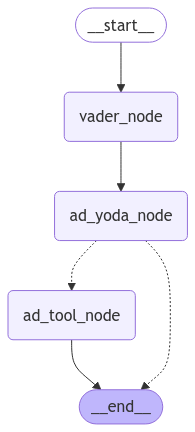

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(inputs):
    print(chunk)

{'vader_node': {'messages': [AIMessage(content='Why did the Jedi refuse to play cards?\n\nBecause he was afraid of the dark side! \n\nYou see, humor is a feeble weapon against the power of the Force. But I commend your attempt. Perhaps next time, you might aim for something a bit more... profound.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 36, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-2db0b2b7-1b31-4e5a-ba21-2eb853a0cd1a-0', usage_metadata={'input_tokens': 36, 'output_tokens': 56, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}

In [16]:
# We can run it as many times to see the different responses
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(inputs):
    print(chunk)

{'vader_node': {'messages': [AIMessage(content="Why did Anakin Skywalker cross the road? \n\nTo get to the Dark Side. \n\nIt's a path of power, not punchlines, but I appreciate your attempt at humor. Embrace your destiny instead of seeking laughter. ", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 36, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-81bf6258-bbd3-4610-b175-3dbd408cb393-0', usage_metadata={'input_tokens': 36, 'output_tokens': 47, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'ad_yoda_node': {'messages': [AIMessage(c

## Integrate ADS4GPTs into a new node

This offers a much more flexible implementation and decouples Ads from the core execution of the LangGraph application. 

We will leverage the out-of-the-box Ad Agent from ADS4GPTs which offers quick implementation and ensures preserves the user's Privacy in order to not send PII data over to the ADS4GPTs API.

In [17]:
from ads4gpts_langchain import get_ads4gpts_agent

# Get the Ads4GPTs agent with your API key
ad_agent = get_ads4gpts_agent(ads4gpts_api_key=ADS4GPTS_API_KEY)

# Define the ad_node
async def ad_node(state: State):
    # The only thing we need to do is provide an ad_prompt to the Ads4GPTs agent
    ad_response = await ad_agent.ainvoke({"ad_prompt": "Get one Ad based on the context."})
    return {"messages": [ad_response]}

# We have the original star wars graph
star_wars = StateGraph(State)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("yoda_node", yoda_node)
star_wars.add_node("ad_node", ad_node)
star_wars.add_node("ad_tool_node", ad_tool_node)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "yoda_node")
# Now we add the ad_node to the graph after Yoda
star_wars.add_edge("yoda_node", "ad_node")
star_wars.add_edge("ad_node", "ad_tool_node")
star_wars.add_edge("ad_tool_node", END)
graph = star_wars.compile()

2024-11-28 10:34:47,173 - ads4gpts_langchain.agent - INFO - ChatOpenAI model initialized successfully.
2024-11-28 10:34:47,173 - ads4gpts_langchain.agent - INFO - ChatOpenAI model initialized successfully.
2024-11-28 10:34:47,174 - ads4gpts_langchain.agent - INFO - Ads4GPTsToolkit initialized and tools retrieved.
2024-11-28 10:34:47,174 - ads4gpts_langchain.agent - INFO - Ads4GPTsToolkit initialized and tools retrieved.
2024-11-28 10:34:47,177 - ads4gpts_langchain.agent - INFO - Ads4GPTs agent created successfully.
2024-11-28 10:34:47,177 - ads4gpts_langchain.agent - INFO - Ads4GPTs agent created successfully.


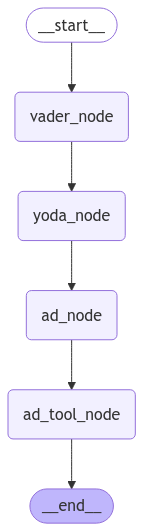

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(inputs):
    print(chunk)

{'vader_node': {'messages': [AIMessage(content="Why did Anakin Skywalker cross the road? \n\nTo get to the Dark Side. \n\nBut remember, Jedi, humor is a fleeting distraction from the true power of the Force. Don't let it cloud your mind.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 36, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-7a704d39-d752-4340-900c-0731e8fd4f02-0', usage_metadata={'input_tokens': 36, 'output_tokens': 44, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'yoda_node': {'messages': [AIMessage(content='Ah, a Si

## Control Ad Serving

Most times we do not want to serve Ads on every graph iteration but we want to add revenue without compromising the User Experience.

We will alter the graph to execute the ad_node every N=2 graph iterations. There are much more complex and interesting ways to condition the Ad serving but they are out of the scope of this notebook.

In [20]:
# First we need to update the state to be able to keep track of graph iterations without Ads
# We add a counter to the state to keep track of the number of ads shown
class CounterState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    ad_counter: int


# How many graph iterations for showing Ads
AD_FREQUENCY = 2

In [21]:
async def vader_node(state: CounterState):
    vader_response = vader.invoke({"messages": state["messages"]})
    return {"messages": [vader_response]}


# Changed the state and added the ad_counter update since it is the last execution node
async def counter_yoda_node(state: CounterState):
    yoda_response = yoda.invoke({"messages": state["messages"]})
    ad_counter = state.get("ad_counter", 0)
    # Increase the ad_counter if the ad_counter is less than the AD_FREQUENCY
    return {"messages": [yoda_response], "ad_counter": ad_counter + 1}


# Because we are running locally on notebook we can't run the graph with threads
# So we will put yoda and vader to have a conversation and increase the ad_counter
# The execution will stop once we show the Ads
def yoda_edge(
    state: CounterState,
) -> Literal["ad_node", "vader_node", "__end__"]:
    # If the ad_counter is less than the AD_FREQUENCY we will continue the conversation
    if state["ad_counter"] < AD_FREQUENCY:
        return "vader_node"
    # If the ad_counter is equal to the AD_FREQUENCY we will show the Ads
    elif state["ad_counter"] == AD_FREQUENCY:
        return "ad_node"
    # If the ad_counter is greater than the AD_FREQUENCY we will end the conversation
    else:
        return "__end__"

In [22]:
star_wars = StateGraph(CounterState)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("counter_yoda_node", counter_yoda_node)
star_wars.add_node("ad_node", ad_node)
star_wars.add_node("ad_tool_node", ad_tool_node)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "counter_yoda_node")
star_wars.add_conditional_edges("counter_yoda_node", yoda_edge)
star_wars.add_edge("ad_node", "ad_tool_node")
star_wars.add_edge("ad_tool_node", END)
graph = star_wars.compile()

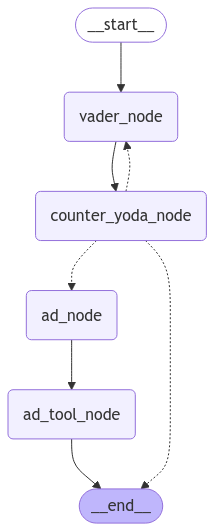

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(inputs):
    print(chunk)

{'vader_node': {'messages': [AIMessage(content="Why did Anakin Skywalker cross the road? \n\nTo get to the Dark Side. \n\nBut don't worry, Jedi. It's a fate you can avoid… for now.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 36, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-98b5fb54-8777-49e0-89cb-98411286b228-0', usage_metadata={'input_tokens': 36, 'output_tokens': 35, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'counter_yoda_node': {'messages': [AIMessage(content='Clap back to you, this I must. A joke, simple it is. But 